In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import Messinger
from Messinger import fem_velocidades  
import Messinger.Procesado_aerodinamico
from Messinger.Procesado_aerodinamico import Procesado_aerodinamico
from Messinger.Procesado_termico import procesado_termico,procesado_termico_borde_ataque
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pywt
import tkinter as tk
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, peak_prominences
import scipy
from tkinter import filedialog
from tkinter import *

In [2]:
V_inf = int(70)
os.chdir('Messinger')
alpha=10
x_experimental = np.arange(0,0.05,0.002)
T_experimental = np.arange(0,0.05,0.002)
(Elementos,Velocidades,Superficie,Puntos)=Procesado_aerodinamico(V_inf,alpha)

In [3]:
df = pd.DataFrame(data =[[2.54,5,12.4,20.4,30.3,40.3,49,60],['A8','A7','A6','A5','A4','A3','A2','A1']])
df=df.T
df.columns = ['s(mm)','sensor']

In [4]:
zona='intrados'
(Elementos,Velocidades,Superficie,Puntos)=Procesado_aerodinamico(V_inf,alpha)
Superficie = Superficie[Superficie['y']>=0]
Modelo = fem_velocidades.modelo_fem(Elementos,Velocidades,Superficie,Puntos)
x_superficie=np.array(Superficie['x'])
y_superficie = np.array(Superficie['y'])
s_perfil = [0]
for i in range(1,len(Modelo.x_superficie)):   
    delta_S= (Modelo.x_superficie[i]-Modelo.x_superficie[i-1])**2+(Modelo.y_superficie[i]-Modelo.y_superficie[i-1])**2
    s_perfil.append(np.sqrt(delta_S)+s_perfil[-1])
X=[] 
df['s(m)'] =df['s(mm)']*10**-3  
for s in df['s(m)']:    
    for i in range(1,len(s_perfil)):     
            if s>=s_perfil[i-1] and s<=s_perfil[i]:
                X.append(Modelo.x_superficie[i-1]+(Modelo.x_superficie[i]-Modelo.x_superficie[i-1])/(s_perfil[i]-s_perfil[i-1])*(s-s_perfil[i-1]))
                break
df['x(m)']=X
print(df)

  s(mm) sensor     s(m)      x(m)
0  2.54     A8  0.00254  0.000763
1     5     A7    0.005  0.002403
2  12.4     A6   0.0124  0.008875
3  20.4     A5   0.0204  0.016510
4  30.3     A4   0.0303  0.026211
5  40.3     A3   0.0403  0.036118
6    49     A2    0.049  0.044780
7    60     A1     0.06  0.055760


In [5]:
X={}
for i in range(len(df['x(m)'])-1):
    n_sensor=int(df['sensor'].loc[i][-1])
    X.update({'FBG'+str(n_sensor):-df['x(m)'].loc[i+1]})
    n_sensor=int(df['sensor'].loc[i][-1])+8
    X.update({'FBG'+str(n_sensor):df['x(m)'].loc[i+1]})
print(X)

{'FBG8': -0.002403067215485018, 'FBG16': 0.002403067215485018, 'FBG7': -0.008875106836142116, 'FBG15': 0.008875106836142116, 'FBG6': -0.016510196715075517, 'FBG14': 0.016510196715075517, 'FBG5': -0.02621094848487953, 'FBG13': 0.02621094848487953, 'FBG4': -0.03611847338013922, 'FBG12': 0.03611847338013922, 'FBG3': -0.044780487828938204, 'FBG11': 0.044780487828938204, 'FBG2': -0.05576011471708383, 'FBG10': 0.05576011471708383}


In [6]:
def procesado_LWC(nombre_ensayo):
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize =(15,7))
    fig.tight_layout(pad=10.0)
    nombre_archivo =f'E://Ensayos_Rime_10//ensayo_{nombre_ensayo}_RIME_10grados.txt'
    file = open(nombre_archivo,'r')
    lineas = file.readlines()
    file.close()
    LWC = lineas[1]
    for caracter in range(len(LWC)):
        if LWC[caracter]=='=':
            lwc = float(LWC[caracter+1:-1])
    MVD = lineas[2]
    for caracter in range(len(MVD)):
        if MVD[caracter]=='=':
            mvd = int(MVD[caracter+1:-1])
    df = pd.read_csv(nombre_archivo,header=3,sep='\t',index_col=False)

    df = df[df['Tiempo (s)']<140]
    df.index =df['Tiempo (s)']
    LWC=lwc
    V=70
    ax.set_title(str(lineas[1])+ str(MVD))
    T_remanso=np.mean(df['FBG1'].loc[110:120])
    MVD = mvd
    Posiciones = []
    temperaturas =[]
    for sensor in X:
        try:
            temperaturas.append(float(np.mean(df[sensor].loc[85:95])))
        except:
            temperaturas.append(0)
        Posiciones.append(X[sensor])
    DF = pd.DataFrame()
    DF['x(m)']=Posiciones
    DF['T(ºC)']=temperaturas
    DF = DF[np.abs(DF['x(m)'])!=X['FBG15']]
    DF=DF.sort_values(by=['x(m)'])
    T_le = list(DF[DF['x(m)']==X['FBG8']]['T(ºC)'])[0]
    print(lwc,T_le)
    plt.plot(lwc,T_le,'k+')
    (Elementos,Velocidades,Superficie,Puntos)=Procesado_aerodinamico(V,alpha)
    Modelo = fem_velocidades.modelo_fem(Elementos,Velocidades,Superficie,Puntos)
    for MVD in np.arange(20,90,20):
        T=[]
        betha=pickle.load(open('Eficiencias_coleccion//betha'+str(V)+'_'+str(alpha)+'_'+str(MVD)+'.p', "rb"))
        for LWC in np.arange(0,1.2,0.1):
            zona_estudio = 'extrados'
            (x_ext,T_sur_ext)=procesado_termico_borde_ataque(alpha,LWC,T_remanso,MVD,zona_estudio,V,Modelo,betha)
            T.append(T_sur_ext)
        print(MVD)
        plt.plot(np.arange(0,1.2,0.1),T,label=str(MVD))
    plt.grid()
    plt.xlabel(r'$LWC(g/m^{3})$')
    plt.ylabel('T(ºC)')
    plt.legend()

In [9]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize =(15,15))
fig.tight_layout(pad=10.0)
nombre_archivo =f'E://Ensayos_Rime_10//ensayo_6C_RIME_10grados.txt'
file = open(nombre_archivo,'r')
lineas = file.readlines()
file.close()
LWC = lineas[1]
for caracter in range(len(LWC)):
    if LWC[caracter]=='=':
        lwc = float(LWC[caracter+1:-1])
MVD = lineas[2]
for caracter in range(len(MVD)):
    if MVD[caracter]=='=':
        mvd = int(MVD[caracter+1:-1])
df = pd.read_csv(nombre_archivo,header=3,sep='\t',index_col=False)

df = df[df['Tiempo (s)']<140]
df.index =df['Tiempo (s)']
x_experimental = [0,0.01,0.02,0.039]
T_experimental = [-2.5, -3,-5.5,-5.5]
LWC=lwc
V=70
ax.set_title(str(lineas[1])+ str(MVD))
T_remanso=np.mean(df['FBG1'].loc[110:120])
MVD = mvd
Posiciones = []
temperaturas =[]
for sensor in X:
    try:
        temperaturas.append(float(np.mean(df[sensor].loc[85:95])))
    except:
        temperaturas.append(0)
    Posiciones.append(X[sensor])
    #ax[fila,columna].plot([Posiciones[-1],Posiciones[-1]],[temperaturas[-1],temperaturas[-1]],'ob',label='experimental')

DF = pd.DataFrame()
DF['x(m)']=Posiciones
DF['T(ºC)']=temperaturas
DF=DF.sort_values(by=['x(m)'])
ax.plot(DF['x(m)'],DF['T(ºC)'],'o-')
for LWC in np.arange(0,1.2,0.1):
    MVD=70
    zona_estudio = 'extrados'
    (x_ext,T_sur_ext)=procesado_termico(alpha,LWC,T_remanso,MVD,zona_estudio,V)
    
    zona_estudio = 'intrados'
    (x_int,T_sur_int)=procesado_termico(alpha,LWC,T_remanso,MVD,zona_estudio,V)
    ax.plot(x_int,T_sur_int,label=str(LWC))
ax.legend()
ax.grid()

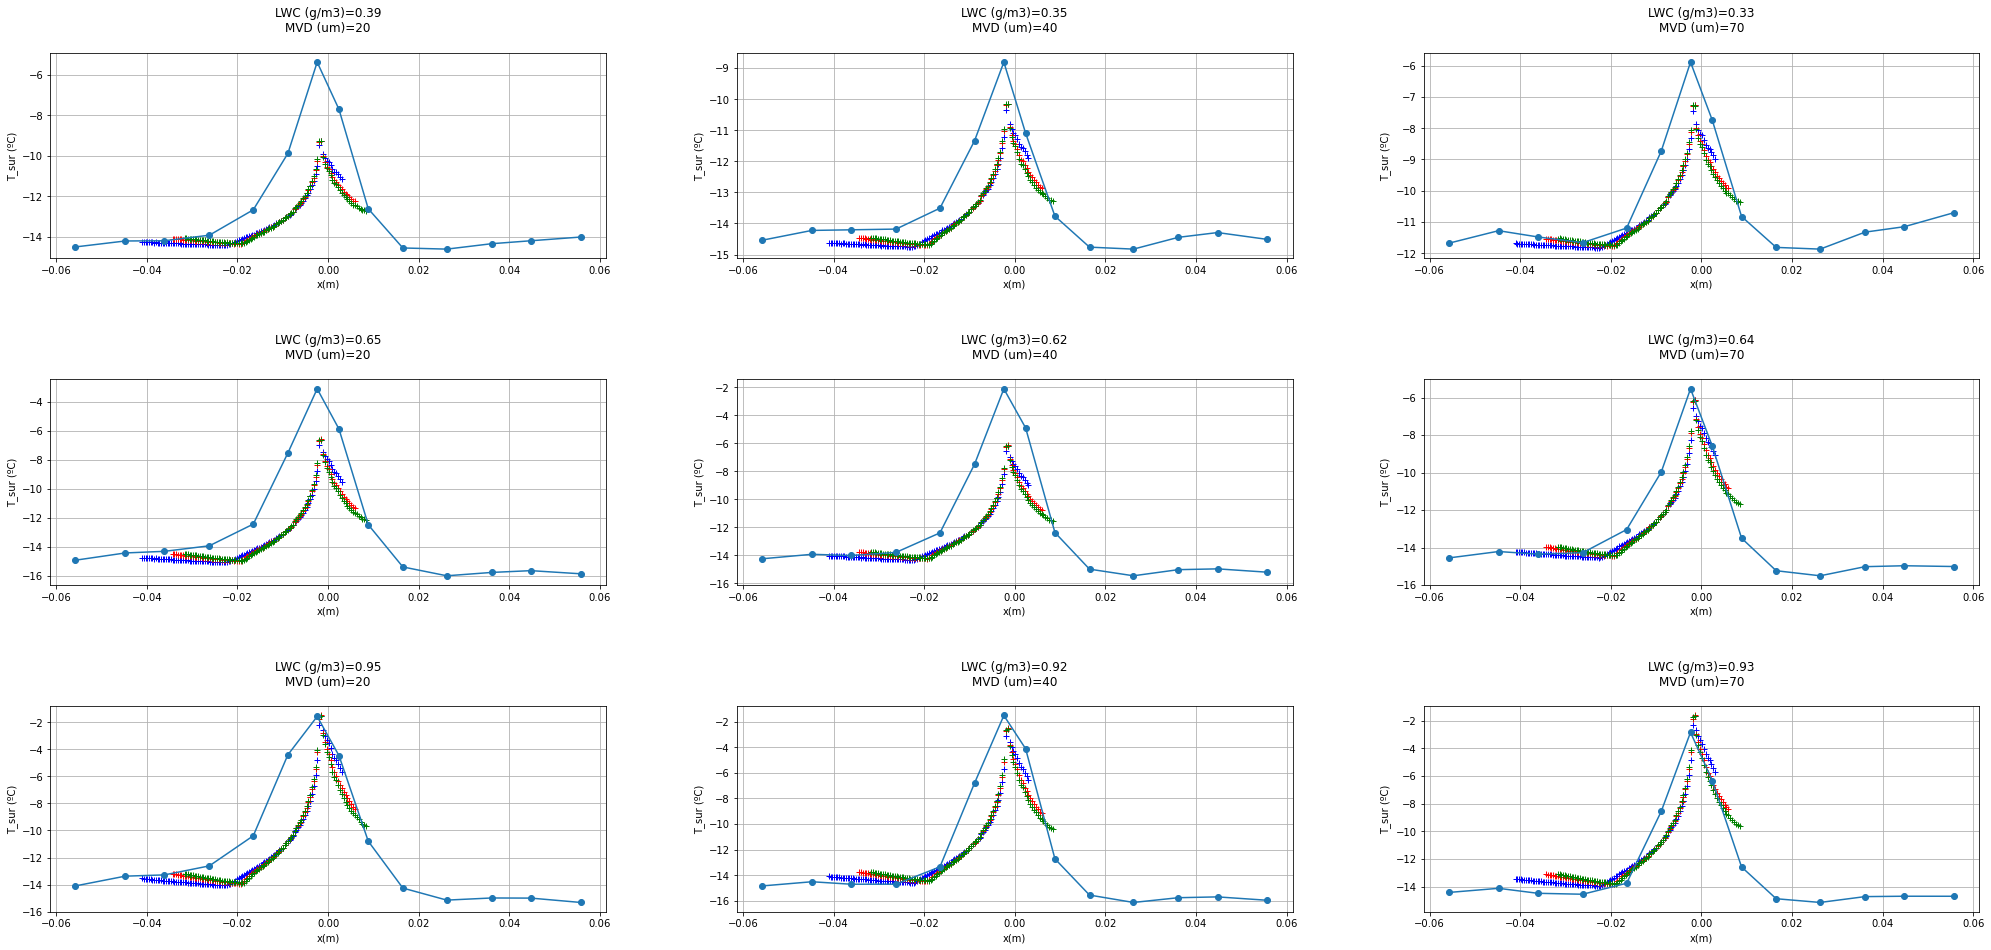

In [12]:
fig,ax = plt.subplots(nrows=3,ncols=3,figsize =(30,15))
fig.tight_layout(pad=10.0)
columna = 0
fila = 0
Datos_rime=[]
for mvD in ['4','5','6']:
    fila = 0
    for lwC in ['A','B','C']:
        nombre_archivo =f'E://Ensayos_Rime_10//ensayo_{mvD}{lwC}_RIME_10grados.txt'
        file = open(nombre_archivo,'r')
        lineas = file.readlines()
        file.close()
        LWC = lineas[1]
        for caracter in range(len(LWC)):
            if LWC[caracter]=='=':
                lwc = float(LWC[caracter+1:-1])
        MVD = lineas[2]
        for caracter in range(len(MVD)):
            if MVD[caracter]=='=':
                mvd = int(MVD[caracter+1:-1])
        df = pd.read_csv(nombre_archivo,header=3,sep='\t',index_col=False)
        if mvD+lwC=='6B':df['Tiempo (s)'] = df['Tiempo (s)']+20
        df = df[df['Tiempo (s)']<140]
        df.index =df['Tiempo (s)']
        x_experimental = [0,0.01,0.02,0.039]
        T_experimental = [-2.5, -3,-5.5,-5.5]
        LWC=lwc
        V=70
        ax[fila,columna].set_title(str(lineas[1])+ str(MVD))
        T_remanso=np.mean(df['FBG1'].loc[110:120])
        MVD = mvd
        alpha =10
        colores={20:'b',40:'r',70:'g'}
        for tamano_gota in [20,40,70]:
            zona_estudio = 'extrados'
            (x_ext,T_sur_ext)=procesado_termico(alpha,LWC,T_remanso,tamano_gota,zona_estudio,V)
            zona_estudio = 'intrados'
            (x_int,T_sur_int)=procesado_termico(alpha,LWC,T_remanso,tamano_gota,zona_estudio,V)
            ax[fila,columna].plot(x_int,T_sur_int,'+'+colores[tamano_gota],label=f'MVD={tamano_gota}')
            ax[fila,columna].plot(x_ext,T_sur_ext,'+'+colores[tamano_gota])
        # ax[fila,columna].axis([-0.02,0.04,-7,0.5])
        ax[fila,columna].set_xlabel('x(m)')
        ax[fila,columna].set_ylabel('T_sur (ºC)')
        ax[fila,columna].grid()
        
        Posiciones = []
        temperaturas =[]
        for sensor in X:
            try:
                temperaturas.append(float(np.mean(df[sensor].loc[85:95])))
            except:
                temperaturas.append(0)
            Posiciones.append(X[sensor])
        DF = pd.DataFrame()
        DF['x(m)']=Posiciones
        DF['T(ºC)']=temperaturas
      
        DF=DF.sort_values(by=['x(m)'])
        ax[fila,columna].plot(DF['x(m)'],DF['T(ºC)'],'o-')
        fila = fila + 1
    ax[fila-1,columna].set_xlabel('x(m)')
    columna = columna + 1 
plt.show()

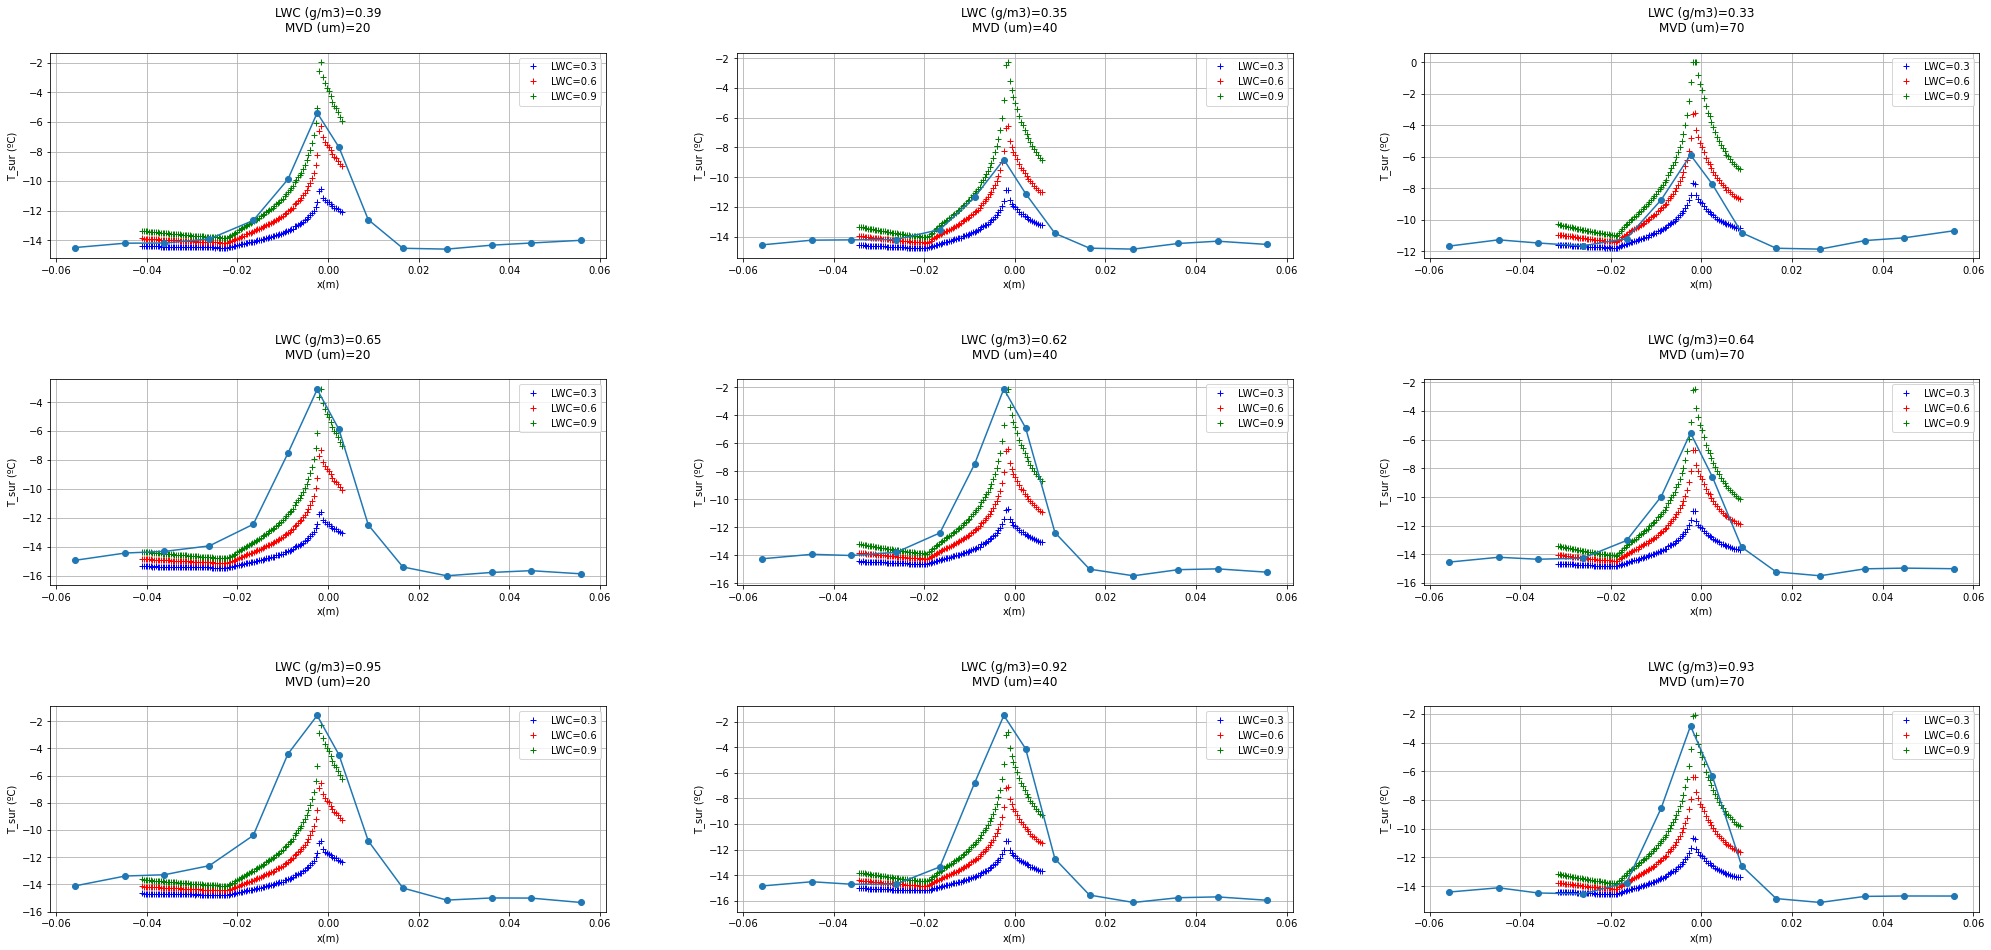

In [14]:
fig,ax = plt.subplots(nrows=3,ncols=3,figsize =(30,15))
fig.tight_layout(pad=10.0)
columna = 0
fila = 0
Datos_rime=[]
for mvD in ['4','5','6']:
    fila = 0
    for lwC in ['A','B','C']:
        nombre_archivo =f'E://Ensayos_Rime_10//ensayo_{mvD}{lwC}_RIME_10grados.txt'
        file = open(nombre_archivo,'r')
        lineas = file.readlines()
        file.close()
        LWC = lineas[1]
        for caracter in range(len(LWC)):
            if LWC[caracter]=='=':
                lwc = float(LWC[caracter+1:-1])
        MVD = lineas[2]
        for caracter in range(len(MVD)):
            if MVD[caracter]=='=':
                mvd = int(MVD[caracter+1:-1])
        df = pd.read_csv(nombre_archivo,header=3,sep='\t',index_col=False)
        if mvD+lwC=='6B':df['Tiempo (s)'] = df['Tiempo (s)']+20
        df = df[df['Tiempo (s)']<140]
        df.index =df['Tiempo (s)']
        x_experimental = [0,0.01,0.02,0.039]
        T_experimental = [-2.5, -3,-5.5,-5.5]
        LWC=lwc
        V=70
        ax[fila,columna].set_title(str(lineas[1])+ str(MVD))
        T_remanso=np.mean(df['FBG1'].loc[110:120])
        MVD = mvd
        alpha =10
        colores={0.3:'b',0.6:'r',0.9:'g'}
        for contenido in [0.3,0.6,0.9]:
            zona_estudio = 'extrados'
            (x_ext,T_sur_ext)=procesado_termico(alpha,contenido,T_remanso,MVD,zona_estudio,V)
            zona_estudio = 'intrados'
            (x_int,T_sur_int)=procesado_termico(alpha,contenido,T_remanso,MVD,zona_estudio,V)
            ax[fila,columna].plot(x_int,T_sur_int,'+'+colores[contenido],label=f'LWC={contenido}')
            ax[fila,columna].plot(x_ext,T_sur_ext,'+'+colores[contenido])
        # ax[fila,columna].axis([-0.02,0.04,-7,0.5])
        ax[fila,columna].set_xlabel('x(m)')
        ax[fila,columna].set_ylabel('T_sur (ºC)')
        ax[fila,columna].grid()
        
        Posiciones = []
        temperaturas =[]
        for sensor in X:
            try:
                temperaturas.append(float(np.mean(df[sensor].loc[85:95])))
            except:
                temperaturas.append(0)
            Posiciones.append(X[sensor])
        DF = pd.DataFrame()
        DF['x(m)']=Posiciones
        DF['T(ºC)']=temperaturas
      
        DF=DF.sort_values(by=['x(m)'])
        ax[fila,columna].plot(DF['x(m)'],DF['T(ºC)'],'o-')
        ax[fila,columna].legend()
        fila = fila + 1
    ax[fila-1,columna].set_xlabel('x(m)')
    columna = columna + 1 
plt.show()

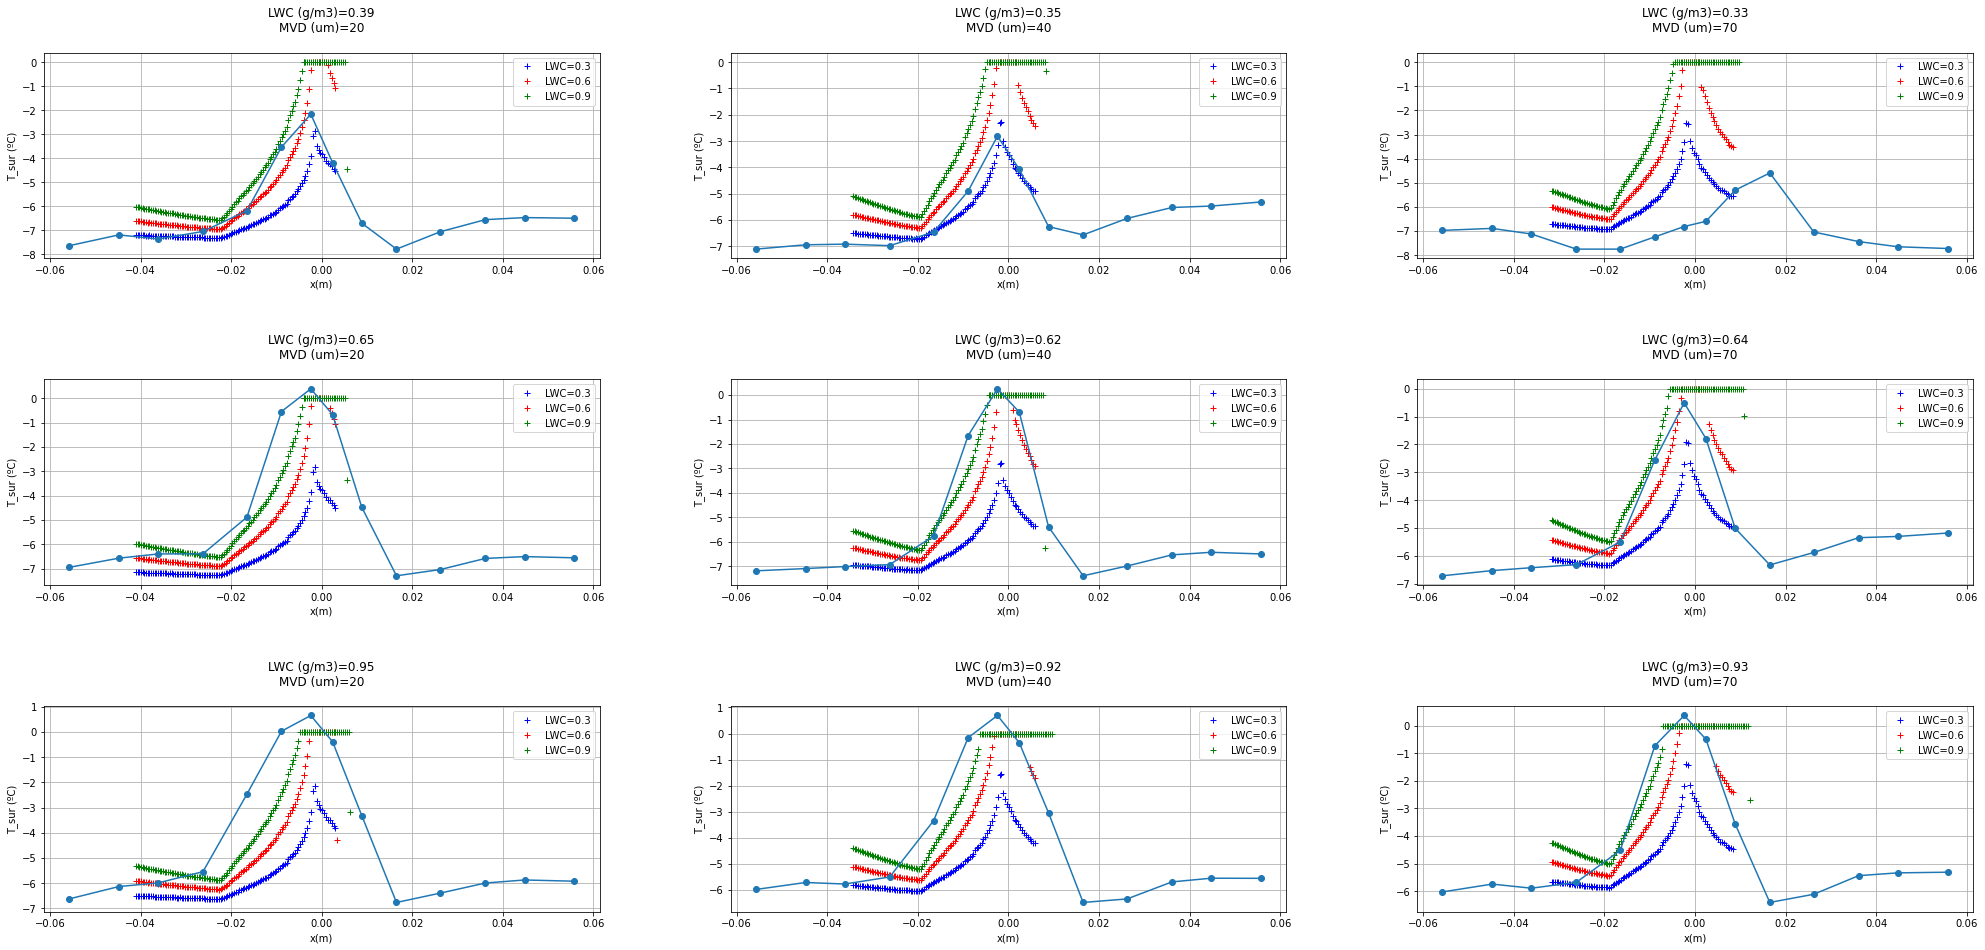

In [15]:

fig,ax = plt.subplots(nrows=3,ncols=3,figsize =(30,15))
fig.tight_layout(pad=10.0)
columna = 0
fila = 0
Datos_rime=[]
for mvD in ['4','5','6']:
    fila = 0
    for lwC in ['A','B','C']:
        nombre_archivo ='E://Ensayos_P7_10_grados//resultados_P7_'+mvD+lwC+'_glaze_10grados.txt'
        file = open(nombre_archivo,'r')
        lineas = file.readlines()
        file.close()
        LWC = lineas[1]
        for caracter in range(len(LWC)):
            if LWC[caracter]=='=':
                lwc = float(LWC[caracter+1:-1])
        MVD = lineas[2]
        for caracter in range(len(MVD)):
            if MVD[caracter]=='=':
                mvd = int(MVD[caracter+1:-1])
        df = pd.read_csv(nombre_archivo,header=3,sep='\t',index_col=False)
        if mvD+lwC=='6B':df['Tiempo (s)'] = df['Tiempo (s)']+20
        df = df[df['Tiempo (s)']<140]
        df.index =df['Tiempo (s)']
        x_experimental = [0,0.01,0.02,0.039]
        T_experimental = [-2.5, -3,-5.5,-5.5]
        LWC=lwc
        V=70
        ax[fila,columna].set_title(str(lineas[1])+ str(MVD))
        T_remanso=np.mean(df['FBG1'].loc[110:120])
        MVD = mvd
        alpha =10
        colores={0.3:'b',0.6:'r',0.9:'g'}
        for contenido in [0.3,0.6,0.9]:
            zona_estudio = 'extrados'
            (x_ext,T_sur_ext)=procesado_termico(alpha,contenido,T_remanso,MVD,zona_estudio,V)
            zona_estudio = 'intrados'
            (x_int,T_sur_int)=procesado_termico(alpha,contenido,T_remanso,MVD,zona_estudio,V)
            ax[fila,columna].plot(x_int,T_sur_int,'+'+colores[contenido],label=f'LWC={contenido}')
            ax[fila,columna].plot(x_ext,T_sur_ext,'+'+colores[contenido])
        # ax[fila,columna].axis([-0.02,0.04,-7,0.5])
        ax[fila,columna].set_xlabel('x(m)')
        ax[fila,columna].set_ylabel('T_sur (ºC)')
        ax[fila,columna].grid()
        
        Posiciones = []
        temperaturas =[]
        for sensor in X:
            try:
                temperaturas.append(float(np.mean(df[sensor].loc[85:95])))
            except:
                temperaturas.append(0)
            Posiciones.append(X[sensor])
        DF = pd.DataFrame()
        DF['x(m)']=Posiciones
        DF['T(ºC)']=temperaturas
      
        DF=DF.sort_values(by=['x(m)'])
        ax[fila,columna].plot(DF['x(m)'],DF['T(ºC)'],'o-')
        ax[fila,columna].legend()
        fila = fila + 1
    ax[fila-1,columna].set_xlabel('x(m)')
    columna = columna + 1 
plt.show()